Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# Tutorial: Train a classification model with automated machine learning

In this tutorial, you'll learn how to generate a  machine learning model using automated machine learning (automated ML).  Azure Machine Learning can perform algorithm selection and hyperparameter selection in an automated way for you. The final model can then be deployed following the workflow in the [Deploy a model](02.deploy-models.ipynb) tutorial.

[flow diagram](./imgs/flow2.png)

Similar to the [train models tutorial](01.train-models.ipynb), this tutorial classifies handwritten images of digits (0-9) from the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset. But this time you don't to specify an algorithm or tune hyperparameters. The automated ML technique iterates over many combinations of algorithms and hyperparameters until it finds the best model based on your criterion.

You'll learn how to:

> * Set up your development environment
> * Access and examine the data
> * Train using an automated classifier locally with custom parameters
> * Explore the results
> * Review training results
> * Register the best model

## Prerequisites

Use [these instructions](https://aka.ms/aml-how-to-configure-environment) to:  
* Create a workspace and its configuration file (**config.json**)  
* Upload your **config.json** to the same folder as this notebook

### Start a notebook

To follow along, start a new notebook from the same directory as **config.json** and copy the code from the sections below.


## Set up your development environment

All the setup for your development work can be accomplished in the Python notebook.  Setup includes:

* Import Python packages
* Configure a workspace to enable communication between your local computer and remote resources
* Create a directory to store training scripts

### Import packages
Import Python packages you need in this tutorial.

In [1]:
import azureml.core
import pandas as pd
from azureml.core.workspace import Workspace
from azureml.train.automl.run import AutoMLRun
import time
import logging
from sklearn import datasets
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
import random
import numpy as np

### Configure workspace

Create a workspace object from the existing workspace. `Workspace.from_config()` reads the file **aml_config/config.json** and loads the details into an object named `ws`.  `ws` is used throughout the rest of the code in this tutorial.

Once you have a workspace object, specify a name for the experiment and create and register a local directory with the workspace. The history of all runs is recorded under the specified experiment.

In [2]:
ws = Workspace.from_config()
# choose a name for the run history container in the workspace
experiment_name = 'dms-automl-classifier'
# project folder
project_folder = './automl-classifier'

import os

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data=output, index=['']).T

Found the config file in: C:\Users\davidsmi\OneDrive - Microsoft\demos\MachineLearningNotebooks\config.json


,
SDK version,0.1.80
Subscription ID,3a06a10f-ae29-4924-b6a7-dda0ea91d347
Workspace,Hal
Resource Group,Robots
Location,eastus
Project Directory,./automl-classifier


## Explore data

The initial training tutorial used a high-resolution version  of the MNIST dataset (28x28 pixels).  Since auto training requires many iterations, this tutorial uses a smaller resolution version  of the images (8x8 pixels) to demonstrate the concepts while speeding up the time needed for each iteration.

In [3]:
from sklearn import datasets

digits = datasets.load_digits()

# Exclude the first 100 rows from training so that they can be used for test.
X_train = digits.data[100:,:]
y_train = digits.target[100:]

### Display some sample images

Load the data into `numpy` arrays. Then use `matplotlib` to plot 30 random images from the dataset with their labels above them.

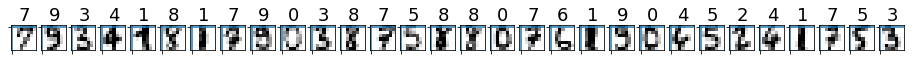

In [4]:
count = 0
sample_size = 30
plt.figure(figsize = (16, 6))
for i in np.random.permutation(X_train.shape[0])[:sample_size]:
    count = count + 1
    plt.subplot(1, sample_size, count)
    plt.axhline('')
    plt.axvline('')
    plt.text(x = 2, y = -2, s = y_train[i], fontsize = 18)
    plt.imshow(X_train[i].reshape(8, 8), cmap = plt.cm.Greys)
plt.show()

You now have the necessary packages and data ready for auto training for your model. 

## Auto train a model 

To auto train a model, first define settings for autogeneration and tuning and then run the automatic classifier.


### Define settings for autogeneration and tuning

Define the experiment parameters and models settings for autogeneration and tuning.  


|Property| Value in this tutorial |Description|
|----|----|---|
|**primary_metric**|AUC Weighted | Metric that you want to optimize.|
|**max_time_sec**|12,000|Time limit in seconds for each iteration|
|**iterations**|20|Number of iterations. In each iteration, the model trains with the data with a specific pipeline|
|**n_cross_validations**|3|Number of cross validation splits|
|**exit_score**|0.9985|*double* value indicating the target for *primary_metric*. Once the target is surpassed the run terminates|
|**blacklist_algos**|['kNN','LinearSVM']|*Array* of *strings* indicating algorithms to ignore.


In [31]:
from azureml.train.automl import AutoMLConfig

##Local compute 
Automl_config = AutoMLConfig(task = 'classification',
                             primary_metric = 'accuracy',
                             iteration_timeout_minutes = 200,
                             iterations = 20,
                             n_cross_validations = 3,
                             experiment_exit_score = 0.9985,
                             blacklist_models = ['kNN','LinearSVM'],
                             X = X_train,
                             y = y_train,
                             path=project_folder)

### Run the automatic classifier

Start the experiment to run locally. Define the compute target as local and set the output to true to view progress on the experiment.

In [32]:
from azureml.core.experiment import Experiment
experiment=Experiment(ws, experiment_name)
local_run = experiment.submit(Automl_config, show_output=True)

Parent Run ID: AutoML_146df9d7-8941-4695-962f-b5dd79be3ec5
*******************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
*******************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper LogisticRegression       0:00:52       0.9682    0.9682
         1   RobustScaler KNN                               0:00:34       0.9228    0.9682
         2   

--- Logging error ---
Traceback (most recent call last):
  File "C:\Users\davidsmi\AppData\Local\conda\conda\envs\aml\lib\logging\handlers.py", line 72, in emit
    self.doRollover()
  File "C:\Users\davidsmi\AppData\Local\conda\conda\envs\aml\lib\logging\handlers.py", line 173, in doRollover
    self.rotate(self.baseFilename, dfn)
  File "C:\Users\davidsmi\AppData\Local\conda\conda\envs\aml\lib\logging\handlers.py", line 113, in rotate
    os.rename(source, dest)
PermissionError: [WinError 32] The process cannot access the file because it is being used by another process: 'C:\\Users\\davidsmi\\OneDrive - Microsoft\\demos\\MachineLearningNotebooks\\tutorials\\automl.log' -> 'C:\\Users\\davidsmi\\OneDrive - Microsoft\\demos\\MachineLearningNotebooks\\tutorials\\automl.log.1'
Call stack:
  File "C:\Users\davidsmi\AppData\Local\conda\conda\envs\aml\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\davidsmi\AppData\Local\conda\conda\envs\aml\lib\run

StandardScalerWrapper KNN                      0:00:29       0.9652    0.9682
         3   StandardScalerWrapper KNN                      0:00:20       0.9758    0.9758
         4   StandardScalerWrapper LightGBM                 0:00:54       0.9623    0.9758
         5   RobustScaler LogisticRegression                0:00:29       0.9652    0.9758
         6   StandardScalerWrapper LogisticRegression       0:00:29       0.9493    0.9758
         7   StandardScalerWrapper SGD                      0:00:18       0.8945    0.9758
         8   StandardScalerWrapper LightGBM                 0:00:15       0.9275    0.9758
         9   MaxAbsScaler RandomForest                      0:00:20       0.8686    0.9758
        10   RobustScaler LogisticRegression                0:00:23       0.9499    0.9758
        11   StandardScalerWrapper SGD                      0:00:25       0.9564    0.9758
        12   MaxAbsScaler LightGBM                          0:00:28       0.9593    0.9758
        13  

 Ensemble                                      0:01:19       0.9829    0.9829


## Explore the results

Explore the results of automatic training with a Jupyter widget or by examining the experiment history.

### Jupyter widget

Use the Jupyter notebook widget to see a graph and a table of all results.

In [33]:
from azureml.widgets import RunDetails
RunDetails(local_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'NOTSET', …

### Retrieve all iterations

View the experiment history and see individual metrics for each iteration run.

In [34]:
children = list(local_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

import pandas as pd
rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
AUC_macro,0.999012,0.995329,0.998831,0.995627,0.999014,0.998592,0.995747,0.987164,0.995916,0.987986,0.995997,0.996654,0.998699,0.995409,0.990563,0.998109,0.994306,0.998690,0.930653,0.999500
AUC_micro,0.999282,0.996334,0.999016,0.995639,0.999060,0.998966,0.994647,0.984690,0.995922,0.988392,0.996980,0.997198,0.998862,0.995719,0.990613,0.998375,0.994925,0.998940,0.916937,0.999659
AUC_weighted,0.999008,0.995327,0.998831,0.995582,0.999001,0.998622,0.995762,0.987131,0.995914,0.988044,0.995965,0.996705,0.998684,0.995342,0.990537,0.998130,0.994233,0.998699,0.931357,0.999503
accuracy,0.968182,0.922813,0.965236,0.975840,0.962294,0.965237,0.949325,0.894519,0.927523,0.868597,0.949920,0.956392,0.959343,0.922810,0.901583,0.949318,0.915736,0.959343,0.559226,0.982913
accuracy_max,0.968182,0.968182,0.968182,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.975840,0.982913
average_precision_score_macro,0.993542,0.971716,0.993350,0.985067,0.993386,0.991006,0.976002,0.926325,0.977481,0.935766,0.976641,0.985232,0.991718,0.973139,0.954088,0.987966,0.967261,0.992120,0.748539,0.997027
average_precision_score_micro,0.994735,0.974953,0.994107,0.984899,0.993545,0.992203,0.973180,0.912887,0.977622,0.935726,0.980270,0.986111,0.992454,0.974405,0.954163,0.988951,0.970899,0.993115,0.570961,0.997523
average_precision_score_weighted,0.993466,0.971723,0.993454,0.984780,0.993391,0.991095,0.976261,0.926728,0.977684,0.936426,0.976328,0.985209,0.991751,0.973139,0.954532,0.988070,0.966997,0.992080,0.751903,0.997037
balanced_accuracy,0.969304,0.922627,0.965062,0.975780,0.962803,0.966167,0.949936,0.894372,0.928098,0.868241,0.950611,0.957491,0.959652,0.923553,0.901740,0.950735,0.915846,0.960447,0.560369,0.983346
f1_score_macro,0.968965,0.921767,0.965093,0.975648,0.962558,0.965872,0.949607,0.889624,0.927533,0.866074,0.950172,0.956143,0.959849,0.922965,0.901102,0.949363,0.915816,0.959837,0.486968,0.983177


## Register the best model 

Use the `local_run` object to get the best model and register it into the workspace. 

In [35]:
# find the run with the highest accuracy value.
best_run, fitted_model = local_run.get_output()

# register model in workspace
description = 'Automated Machine Learning Model'
tags = None
local_run.register_model(description=description, tags=tags)
local_run.model_id # Use this id to deploy the model as a web service in Azure

Registering model AutoML146df9d78best


'AutoML146df9d78best'

## Test the best model

Use the model to predict a few random digits.  Display the predicted and the image.  Red font and inverse image (white on black) is used to highlight the misclassified samples.

Since the model accuracy is high, you might have to run the following code a few times before you can see a misclassified sample.

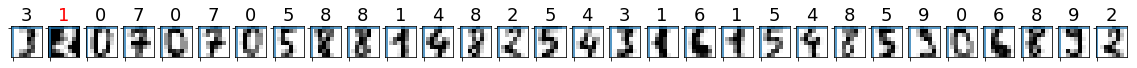

In [30]:
# find 30 random samples from test set
n = 30
X_test = digits.data[:100, :]
y_test = digits.target[:100]
sample_indices = np.random.permutation(X_test.shape[0])[0:n]
test_samples = X_test[sample_indices]


# predict using the  model
result = fitted_model.predict(test_samples)

# compare actual value vs. the predicted values:
i = 0
plt.figure(figsize = (20, 1))

for s in sample_indices:
    plt.subplot(1, n, i + 1)
    plt.axhline('')
    plt.axvline('')
    
    # use different color for misclassified sample
    font_color = 'red' if y_test[s] != result[i] else 'black'
    clr_map = plt.cm.gray if y_test[s] != result[i] else plt.cm.Greys
    
    plt.text(x = 2, y = -2, s = result[i], fontsize = 18, color = font_color)
    plt.imshow(X_test[s].reshape(8, 8), cmap = clr_map)
    
    i = i + 1
plt.show()

## Next steps

In this Azure Machine Learning tutorial, you used Python to:

> * Set up your development environment
> * Access and examine the data
> * Train using an automated classifier locally with custom parameters
> * Explore the results
> * Review training results
> * Register the best model

Learn more about [how to configure settings for automatic training](https://aka.ms/aml-how-to-configure-auto) or [how to use automatic training on a remote resource](https://aka.ms/aml-how-to-auto-remote).